## Multiclass Image Classification Project

### Challenge - PokeMon's on Goa Trip

**Description** - You are going on a trip to Dudhsagar Falls, Goa. To reach the falls you have to cross a huge forest in Collem, so you thought of entering the forest. While you are on your route you spotted multiple Pokemons like Bulbasaur, Pikachu, and Charmender. After coming back, you thought of making a PokeDex - a Pokemon Detector Device which classifies these Pokemons. Write an algorithm that classifies these PokeMons.

**Approach** - Classification of Pokemons using SVM implementation from scratch.

In [1]:
import numpy as np
from keras.preprocessing import image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [2]:
## Training Data

path = Path("Train")  ## Path of the directory containing the folders with images - training data
dirs = path.glob("*")   ## Directories within the path

labels_encoded = {"Pikachu":0, "Bulbasaur":1, "Charmander":2} ## encoding the categories in the dictionary - labels

image_data = []
labels = []

for folder in dirs:
    label = str(folder).split("\\")[1]
    
    for img_path in folder.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(32,32))  ## Load every image with size = 32x32
        img_array = image.img_to_array(img)  ## Convert the image into a 32,32,3 array (RGB)
        image_data.append(img_array)         ## Append the array to the list of image_data
        labels.append(labels_encoded[label]) ## Store the label for the given image

c:\users\kanav mehra\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
## Testing Data

test_path = Path("Test")  ## Path of the directory containing the folders with images - testing data
test_dirs = test_path.glob("*")   ## Directories within the test path

test_data = []
file_names = []

for folder in test_dirs:
    for img_path in folder.glob("*.jpg"):
        file_names.append(img_path.name)
        img = image.load_img(img_path, target_size=(32,32))  ## Load every image with size = 32x32
        img_array = image.img_to_array(img)  ## Convert the image into a 32,32,3 array (RGB)
        test_data.append(img_array)         ## Append the array to the list of image_data

In [4]:
## Storing as a numpy array

image_data = np.array(image_data, dtype='float32')/255.0  ## Normalising the pixel values (0 to 1)
labels = np.array(labels)

test_data = np.array(test_data, dtype='float32')/255.0  ## Normalising the pixel values (0 to 1)

print(image_data.shape)
print(labels.shape)
print(test_data.shape)

(304, 32, 32, 3)
(304,)
(123, 32, 32, 3)


### Random Shuffling of Data for Training Purpose

In [5]:
import random

combined = list(zip(image_data, labels))  ## Zip the data and label together as a tuple into a list 
random.shuffle(combined)

## Unzip the data
image_data[:], labels[:] = zip(*combined)

In [6]:
print(image_data.shape)
print(labels.shape)

(304, 32, 32, 3)
(304,)


### View Image

In [7]:
def plotImage(img, label):
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

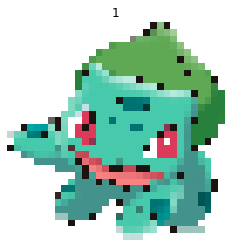

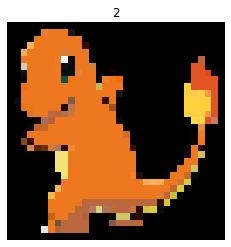

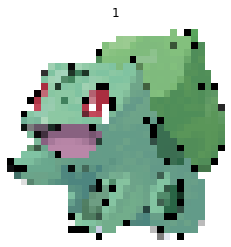

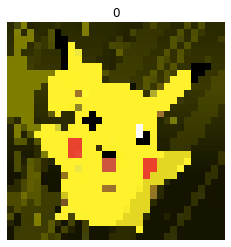

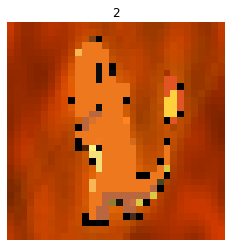

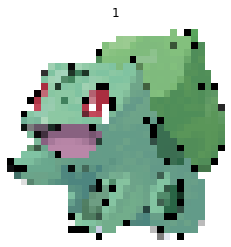

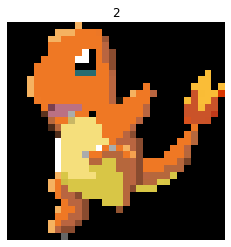

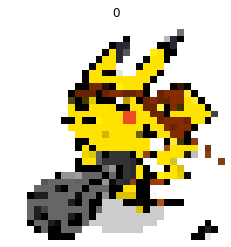

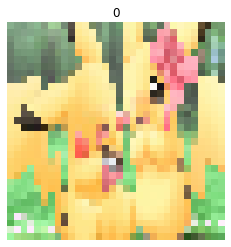

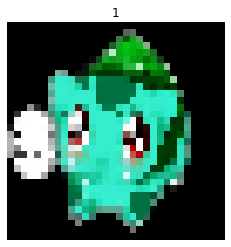

In [8]:
for i in range(10):
    plotImage(image_data[i], labels[i])

### Reshape Data

In [9]:
## Flatten the 32x32x3 array into a single dimensional array

no_of_samples_train = image_data.shape[0]
no_of_samples_test = test_data.shape[0]

image_data = image_data.reshape(no_of_samples_train,-1)
test_data = test_data.reshape(no_of_samples_test,-1)

print(image_data.shape)
print(test_data.shape)

(304, 3072)
(123, 3072)


### Prepare Data for One v One Classification

In [10]:
CLASSES = len(np.unique(labels)) ## No.of labels/classes

In [107]:
def classWiseDate(X, Y):
    '''Arrange the data in class wise fashion'''
    
    data = {}
    
    for i in range(CLASSES):
        data[i] = []  ## Empty list for every label
    
    for i in range(X.shape[0]):
        data[Y[i]].append(X[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [108]:
data = classWiseDate(image_data, labels)

In [109]:
def pairWiseData(X1, X2):
    '''Generates a combined dataset for 2 distinct datasets representing different classes'''
    
    no_of_samples_X1 = X1.shape[0]
    no_of_samples_X2 = X2.shape[0]
    no_of_features = X1.shape[1]
    
    total_samples = no_of_samples_X1 + no_of_samples_X2
    
    combined_X = np.zeros((total_samples, no_of_features))
    combined_Y = np.zeros((total_samples,))
    
    combined_X[:no_of_samples_X1,:] = X1
    combined_X[no_of_samples_X1:,:] = X2
    combined_Y[:no_of_samples_X1] = -1
    combined_Y[no_of_samples_X1:] = 1
    
    return combined_X, combined_Y

### SVM Classifier

In [110]:
class SVM:
    '''Implementation of SVM Classifier using PEGASOS Algorithm'''
    
    def __init__(self,C=1.0):
        self.W = 0
        self.b = 0
        self.C = C
        
    def hingeLoss(self, X, Y, W, b):
        '''Implementation of Hinge loss'''
        
        loss = 0.5*np.dot(W,W.T)
        samples = X.shape[0]
        
        for i in range(samples):
            ti = Y[i]*(np.dot(W, X[i].T) + b)
            loss = loss + self.C*max(0, (1-ti))
            
        return loss[0][0]
    
    def fit(self, X, Y, learning_rate=0.001, maxIter=100, batch_size=50):
        '''Pegasos Implementation - Batch Gradient Descent with Random Shuffling'''
        
        no_of_samples = X.shape[0]
        no_of_features = X.shape[1]
        
        W = np.zeros((1, no_of_features))
        b = 0
        
        losses = []
        
        for k in range(maxIter):
            loss = self.hingeLoss(X, Y, W, b)
            losses.append(loss)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0, no_of_samples, batch_size):
                grad_w = 0
                grad_b = 0
                for j in range(batch_start, batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti = Y[i]*(np.dot(W, X[i].T) + b)
                        
                        ## Case 1 : No Error
                        if ti>1:
                            grad_w += 0
                            grad_b += 0 
                        
                        ## Case 2 : Error
                        else:
                            grad_w += self.C*Y[i]*X[i]
                            grad_b += self.C*Y[i]
                            
                ## Update Rule
                W = W - learning_rate*W + learning_rate*grad_w
                b = b + learning_rate*grad_b
        
        self.W = W
        self.b = b
        
        return losses, W, b

### Training nC2 SVM Classifiers

In [111]:
def trainSVMs(X, Y):
    
    classifiers = {}
    for i in range(CLASSES):
        classifiers[i] = {}
        for j in range(i+1, CLASSES):
            mySVM = SVM()
            xp, yp = pairWiseData(data[i], data[j])
            loss, W, b = mySVM.fit(xp,yp,learning_rate=0.00001,maxIter=2500)
            classifiers[i][j] = (W, b)
            plt.plot(loss)
            plt.xlabel("No.of Iterations")
            plt.ylabel("Loss")
            plt.title("Class "+str(i)+" and "+"Class "+str(j))
            plt.show()
    
    return classifiers

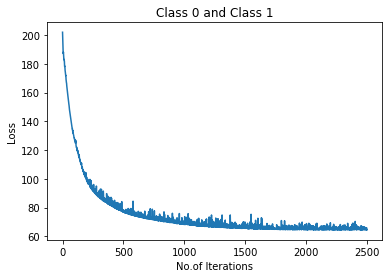

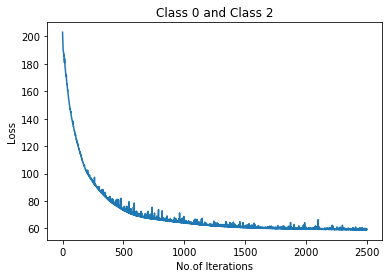

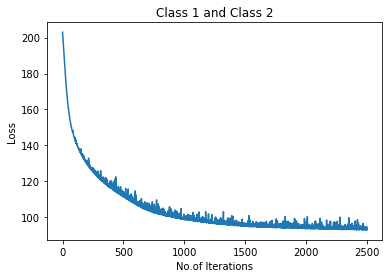

In [112]:
classifiers = trainSVMs(image_data, labels)

### Prediction

In [113]:
def binaryPredict(x, W, b):
    z = np.dot(W, x.T)+b
    if z>=0:
        return 1
    else:
        return -1

In [114]:
def predict(x):
    '''Getting the prediction for a single point x based on majority voting from all classifiers'''
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1, CLASSES):
            W = classifiers[i][j][0]
            b = classifiers[i][j][1]
            prediction = binaryPredict(x, W, b)
            if prediction==1:
                count[j] += 1
            else:
                count[i] += 1
    
    prediction = np.argmax(count)
    
    return prediction

In [115]:
def accuracy(X, Y):
    count = 0
    for i in range(X.shape[0]):
        pred = predict(X[i])
        if pred==Y[i]:
            count += 1
    
    return count/X.shape[0]

In [116]:
train_accuracy = accuracy(image_data, labels)
print(train_accuracy)

0.680921052631579


### Classifying Test Data

In [117]:
y_predictions = []

for i in range(test_data.shape[0]):
    y_predictions.append(predict(test_data[i]))
    
print(y_predictions)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]


In [118]:
for i in range(len(y_predictions)):
    for key in labels_encoded.keys():
        if labels_encoded[key] == y_predictions[i]:
            y_predictions[i] = key

print(y_predictions)

['Bulbasaur', 'Pikachu', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Pikachu', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Charmander', 'Bulbasaur', 'Charmander', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Pikachu', 'Bulbasaur', 'Charmander', 'Bulbasaur', 'Charmander', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Charmander', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Charmander', 'Pikachu', 'Charmander', 'Pikachu', 'Charmander', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Charmander', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Charmander', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu

In [119]:
df_test = pd.read_csv('Test/test.csv')
image_ids = list(df_test['ImageId'])
y_values = []

for img in image_ids:
    idx = file_names.index(img)
    y_values.append(y_predictions[idx])

In [120]:
output = pd.DataFrame({'ImageId':image_ids, 'NameOfPokemon': y_values})
output.to_csv('submission_svm.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
